You can check and explore further methods applied the tasks we have previously covered from the following link:
https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d313030

Skeleton code is provided from the following tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Dataset: https://pytorch.org/docs/stable/_modules/torchvision/datasets/cifar.html#CIFAR100

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import math
from timeit import default_timer as timer

print("Versions..........")
print("torch:       ", torch.__version__)
print("torchvision: ", torchvision.__version__)

D:\Anaconda3\envs\myEnv001\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda3\envs\myEnv001\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\Anaconda3\envs\myEnv001\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Versions..........
torch:        1.10.1+cu102
torchvision:  0.11.2+cu102


### Defining and testing custom image transformation

Files already downloaded and verified


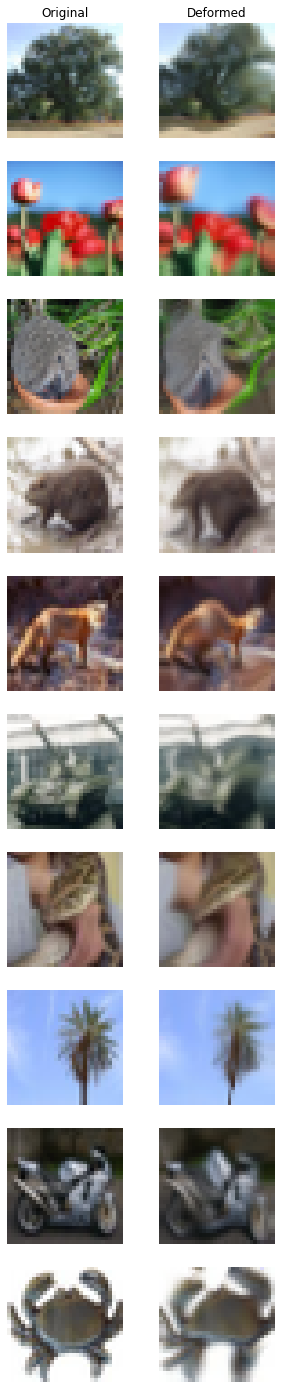

In [2]:
# [DONE] TODO: write at least one data transform or augmentation method yourself ==> DONE
class ElasticDeformation(object):
    """Elastic deformation used as image augmentation for classification task, as per the follwoing paper.
    Simard, Steinkraus and Platt, "Best Practices for Convolutional Neural Networks applied to Visual Document Analysis",
    in Proc. of the International Conference on Document Analysis and Recognition, 2003.

    Note that calling this class's function will treat its image input according to its class.
    If the image is a numpy array, it will be treated like an OpenCV image (channels last; H,W,C)
    If the image is a torch.tensor, it will be treated accordingly (channels first; C,H,W)

    Args:

    :param alpha: Size of distortion (pixels). typical value is between 1.5 and 3 x image height
    :param sigma: Variance of the Gaussian distribution with whom the uniform random displacement fields will be convolved. Typical value is between 0.01 and 0.1 image height.
    :param alpha_affine: Size of the affine transformations. Typical value is between 0.01 and 0.1 image height.
    :param random_state: State of the RNG for reproducibility of random displacement fields. Default is None.
    :param probability: Chance of the transform happening (it is a random deformation). Default is 1.0, meaning the transformation will definitely happen.
    :param output: Type of output for its callable function. Options are 'array' for OpenCV output (channels last), or 'tensor' for PyTorch Tensor (channels first)
    """
    def __init__(self, alpha, sigma, alpha_affine, random_state=None, probability=1.0, output='array'):
        self.alpha = alpha
        self.sigma = sigma
        self.alpha_affine = alpha_affine
        self.random_state = random_state
        self.probability = probability
        self.output = output


    def __call__(self, image):
        """Perform elastic transformation on an image using the class parameters for transformation.
    
        Args:
            :param image (numpy.ndarray or torch.tensor): Input image or tensor of image.
                Note that calling this class's function will treat its image input according to its class.
                If the image is a numpy array, it will be treated like an OpenCV image (channels last; H,W,C)
                If the image is a torch.tensor, it will be treated accordingly (channels first; C,H,W)

        Returns:
            :return image: If output=='array' in constructor, output will be an OpenCV array (channels last), if output=='tensor', a PyTorch tensor (channels first) will be returned.
        """
        if self.random_state is None:
            random_state = np.random.RandomState(None)

        if np.random.uniform() > self.probability:
            if 'tensor' in type(image).__name__.lower():
                if self.output=='tensor':
                    return image
                else:
                    return image.numpy().transpose((1,2,0))
            else:
                if self.output=='tensor':
                    return torch.tensor(image.transpose((2,0,1)))
                else:
                    return image
        
        image = image.numpy().transpose((1,2,0)) if 'tensor' in type(image).__name__.lower() else image
        
        shape = image.shape
        shape_size = shape[:2]
        
        # Random affine
        center_square = np.float32(shape_size) // 2
        square_size = min(shape_size) // 3
        pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
        pts2 = pts1 + random_state.uniform(-self.alpha_affine, self.alpha_affine, size=pts1.shape).astype(np.float32)
        M = cv2.getAffineTransform(pts1, pts2)
        image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), self.sigma) * self.alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), self.sigma) * self.alpha
        dz = np.zeros_like(dx)

        x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
        indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

        out = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
        return out if self.output=='array' else torch.tensor(out.transpose((2,0,1)))


    def __repr__(self):
        return self.__class__.__name__+"(\n"+\
            "    alpha = {},\n".format(self.alpha)+\
            "    sigma = {},\n".format(self.sigma)+\
            "    alpha_affine = {},\n".format(self.alpha_affine)+\
            "    random_state = {},\n".format(self.random_state)+\
            "    probability = {},\n".format(self.probability)+\
            "    output = {})".format(self.output)


def elastic_transform_batch(batch, alpha, sigma, alpha_affine, random_state=None, probability=1.0):
    # Perform Elastic Deformation on a whole batch. Here, batch can also be a torch tensor from a dataloader or something.
    distorter = ElasticDeformation(alpha, sigma, alpha_affine, random_state, probability, output='array')
    return np.concatenate([distorter(img) for img in batch]).reshape(batch.shape)


# Testing the elastic distorter
sampleset = torchvision.datasets.CIFAR100(root='./data/sample', train=False, download=True)
sampledata = sampleset.data[np.random.choice(len(sampleset),10),...]
h,w = sampledata.shape[1:3]
sampledata_deformed = elastic_transform_batch(sampledata, w*1.1, w*0.1, w*0.02)
plt.figure(figsize = (5,25))
i = 0
for idx in range(10):
    i += 1
    plt.subplot(10,2,i)
    plt.imshow(sampledata[idx,...])
    plt.axis('off')
    if i == 1: plt.title('Original')
    i += 1
    plt.subplot(10,2,i)
    plt.imshow(sampledata_deformed[idx,...])
    if i == 2: plt.title('Deformed')
    plt.axis('off')
plt.show()

### Preliminaries and Data Loaders

In [3]:
# [DONE] TODO: You may consider appyling more transform such as data augmentation methods, etc.
# TODO: You may consider hyperparameter optimization: in this cell, we have batch_size!
# [DONE] TODO: use the previously defined data transform/augmentation method in the following transform.

# Global constants
ELASTIC_ALPHA = 32*1.1
ELASTIC_SIGMA = 32*0.1
ELASTIC_ALPHA_AFFINE = 32*0.02
ELASTIC_PROBABILITY = 0.5
P_VERT_FLIP = 0.5
P_HORZ_FLIP = 0.5
JITTER_BRIGHTNESS = 0.1
JITTER_SATURATION = 0.1
JITTER_CONTRAST = 0.2
AFFINE_ROTATION = 50
AFFINE_TRANSLATION = (0.1, 0.1)
AFFINE_SCALE = (0.5, 1.5)
AFFINE_SHEAR = 20
NORM_MEAN = (0.5, 0.5, 0.5)
NORM_STD = (0.5, 0.5, 0.5)
VALIDATION_DATA = 0.2
NUM_HPO_TRIALS = 10
HPO_TIMEOUT_SEC = 3600 * 5
NUM_HPO_JOBS = 1

# Hyperparameters
hparams = {
    'input_image_size':[32, 32],
    'batch_size': 256,
    'epochs': 10,
    'lr': 0.001,
    'loss_function': nn.CrossEntropyLoss(),
    'optimizer':'adam',
    'optimizer_params':None,
    'num_conv_blocks': 3,
    'num_dense_layers':3,
    'conv_kernel_size':5,
    'pool_kernel_size':2,
    'conv_padding':0,
    'pool_padding':0,
    'conv_activations':'relu',
    'dense_activations':'relu',
    'conv_batchnorm':'before',
    'dense_batchnorm':'before',
    'conv_stride':1,
    'pool_stride':1,
    'dense_sizes':[256,128],
    'conv_dropout':0.2,
    'dense_dropout':0.2,
    'L2':0.001,
    'num_classes':100}


transform = transforms.Compose([
        transforms.ToTensor(),
        ElasticDeformation(ELASTIC_ALPHA, ELASTIC_SIGMA, ELASTIC_ALPHA_AFFINE, random_state=None, probability=ELASTIC_PROBABILITY, output='tensor'),
        transforms.RandomVerticalFlip(P_VERT_FLIP),
        transforms.RandomHorizontalFlip(P_HORZ_FLIP),
        transforms.ColorJitter(brightness=JITTER_BRIGHTNESS, contrast=JITTER_CONTRAST, saturation=JITTER_SATURATION),
        transforms.RandomAffine(AFFINE_ROTATION, AFFINE_TRANSLATION, AFFINE_SCALE, AFFINE_SHEAR),
        transforms.Normalize(NORM_MEAN, NORM_STD)])


allset = torchvision.datasets.CIFAR100(root='./data/CIFAR100', train=True, download=True, transform=transform)
num_all_data = len(allset.data)
num_val_data, num_train_data = int(VALIDATION_DATA*num_all_data), int((1-VALIDATION_DATA)*num_all_data)
(trainset, valset) = random_split(allset, (num_train_data, num_val_data), generator=torch.Generator().manual_seed(42))
trainloader = DataLoader(trainset, batch_size=hparams['batch_size'], shuffle=True, num_workers=0)
validloader = DataLoader(valset, batch_size=hparams['batch_size'], shuffle=True, num_workers=0)
testset = torchvision.datasets.CIFAR100(root='./data/CIFAR100', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=hparams['batch_size'], shuffle=False, num_workers=0)

classes = ('apples', 'aquarium fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottles', 
           'bowls', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'cans', 'castle', 'caterpillar', 'cattle', 'chair', 
           'chimpanzee', 'clock', 'cloud', 'cockroach', 'computer keyboard', 'couch', 'crab', 'crocodile', 
           'cups', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 
           'kangaroo', 'lamp', 'lawn-mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple', 'motorcycle', 
           'mountain', 'mouse', 'mushrooms', 'oak', 'oranges', 'orchids', 'otter', 'palm', 'pears', 'pickup truck', 
           'pine', 'plain', 'plates', 'poppies', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 
           'roses', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 
           'streetcar', 'sunflowers', 'sweet peppers', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
           'train', 'trout', 'tulips', 'turtle', 'wardrobe', 'whale', 'willow', 'wolf', 'woman', 'worm')

Files already downloaded and verified
Files already downloaded and verified


### Visualizing some normalized images

Shape of images:  torch.Size([1024, 3, 32, 32])
Shape of labels:  torch.Size([1024])
tensor([49, 90,  8,  ..., 82,  9, 84])


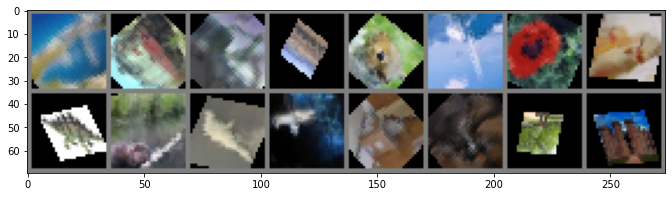

mountain, train, bicycle, plain, squirrel, mountain, poppies, trout,  cups, beaver,  crab, shark, rabbit, motorcycle, willow, castle


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(12,3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)

images, labels = dataiter.next()
#images, labels = testloader[0]
print("Shape of images: ", images.shape)
print("Shape of labels: ", labels.shape)
print(labels)
# show images
imshow(torchvision.utils.make_grid(images[:16]))
# print labels
print(', '.join('%5s' % classes[labels[j]] for j in range(16)))

### Constructing CNN model

In [ ]:
# Base model, not to be used here
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 200)
        self.fc2 = nn.Linear(200, 128)
        self.fc3 = nn.Linear(128, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
# [DONE] (Optional but highly recommended) TODO: You can define your own neural network to create a better performing model!
class ConvNet(nn.Module):
    def __init__(self, hparams:dict):
        super(ConvNet, self).__init__()
        self.hparams = hparams
        self.layers = []
        self._img_size = self.hparams['input_image_size']
        self._h, self._w = self._img_size
        self._img_size_list = [[3, self._h, self._w]]
        self._actdict = {'relu':nn.ReLU(), 'leakyrelu':nn.LeakyReLU(0.1), 'sigmoid':nn.Sigmoid(), 'tanh':nn.Tanh()}

        # Constructing the encoder (feature extractor)
        in_channels = 3
        out_channels = 16
        for i in range(self.hparams['num_conv_blocks']):
            self.layers.append(nn.Conv2d(in_channels, out_channels, self.hparams['conv_kernel_size'], padding=self.hparams['conv_padding'], stride=self.hparams['conv_stride']))
            self._update_image_size(out_channels, 'conv')
            if self.hparams['conv_batchnorm']=='before':
                self.layers.append(nn.BatchNorm2d(out_channels))
            self.layers.append(self._actdict[self.hparams['conv_activations']])
            if self.hparams['conv_batchnorm']=='after':
                self.layers.append(nn.BatchNorm2d(out_channels))
            self.layers.append(nn.MaxPool2d(self.hparams['pool_kernel_size'], padding=self.hparams['pool_padding'], stride=self.hparams['pool_stride']))
            self._update_image_size(out_channels, 'pool')
            if self.hparams.get('conv_dropout'):
                self.layers.append(nn.Dropout2d(self.hparams['conv_dropout']))
            if i < self.hparams['num_conv_blocks'] - 1:
                in_channels = out_channels
                out_channels *= 2

        # Flattening (Image embedding)
        self.layers.append(nn.Flatten())

        # Constructing the decoder (classifier)
        if self.hparams.get('dense_sizes'):
            size_vec = self.hparams.get('dense_sizes')
        else:
            size_vec = [0] * self.hparams['num_dense_layers']
            size_vec[-1] = np.power(2, np.ceil(np.log2(self.hparams['num_classes']))).astype(int)
            for i in range(self.hparams['num_dense_layers']-2, -1, -1):
                size_vec[i] = size_vec[i+1] * 2
        in_size = out_channels*self._h*self._w
        out_size = size_vec[0]
        for i in range(len(size_vec)):
            self.layers.append(nn.Linear(in_size, out_size))
            if self.hparams['dense_batchnorm'] == 'before':
                self.layers.append(nn.BatchNorm1d(out_size))
            self.layers.append(self._actdict[self.hparams['dense_activations']])
            if self.hparams['dense_batchnorm'] == 'after':
                self.layers.append(nn.BatchNorm1d(out_size))
            if self.hparams.get('dense_dropout'):
                self.layers.append(nn.Dropout(self.hparams['dense_dropout']))
            if i < len(size_vec) - 1:
                in_size = out_size
                out_size = size_vec[i+1]
        self.layers.append(nn.Linear(out_size, self.hparams['num_classes']))

        # Constructing model
        self.net = nn.Sequential(*self.layers)

                
    def _calc_size(self, size_in:int, padding:int, kernel_size:int, stride:int):
        if padding == 'valid':
            padding=0
        if padding=='same':
            return size_in
        else:
            return math.floor((size_in + 2*padding - (kernel_size-1) - 1)/stride + 1)
        
    
    def _update_image_size(self, out_channels, ops:str='conv'):
        (self._h, self._w) = (self._calc_size(sz, self.hparams[ops+'_padding'], self.hparams[ops+'_kernel_size'], self.hparams[ops+'_stride']) for sz in (self._h,self._w))
        self._img_size = (self._h, self._w)
        #print("new size: ",self._img_size)
        self._img_size_list.append([out_channels, self._h, self._w])

    def forward(self, x:torch.Tensor):
        return self.net(x)


# Instantiation
inzvaNet = ConvNet(hparams)
print("Built network is:")
print(inzvaNet)
print("Image sizes as they go through the convolution blocks:")
print(np.array(inzvaNet._img_size_list))

Built network is:
ConvNet(
  (net): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.2, inplace=False)
    (5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.2, inplace=False)
    (10): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout2d(p=0.2, inplace=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=18496, ou

### Checking GPU availability

In [5]:
# if you want to train on GPU:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Instantiating CNN and defining training procedure

In [8]:
inzvaNet.to(device)
inzvaNet.train()

# base optimizer with following parameters:
criterion = hparams['loss_function']
if hparams['optimizer']=='adam':
    if hparams.get('optimizer_params'):
        optimizer = optim.Adam(inzvaNet.parameters(), lr=hparams['lr'], **hparams['optimizer_params'])
    else:
        optimizer = optim.Adam(inzvaNet.parameters(), lr=hparams['lr'])
elif hparams['optimizer']=='sgd':
    if hparams.get('optimizer_params'):
        optimizer = optim.SGD(inzvaNet.parameters(), lr=hparams['lr'], **hparams['optimizer_params'])
    else:
        optimizer = optim.SGD(inzvaNet.parameters(), lr=hparams['lr'])
else:
    raise ValueError("Sorry, only 'adam' and 'sgd' are supported for now.")

# optimizer = optim.SGD(inzvaNet.parameters(), lr=0.001, momentum=0.9)
# TODO: play with hyperparameters and chosen methods to achieve higher accuracy! You can apply grid or random search.

### Training

In [9]:
# Training loop
print('training starts!')
num_training_batches = len(trainloader)
num_validation_batches = len(validloader)
num_testing_batches = len(testloader)

tStart = timer()
for epoch in range(hparams["epochs"]):
    
    epoch_loss_training = 0.0
    epoch_loss_validation = 0.0

    inzvaNet.train()
    for i, data in enumerate(trainloader):
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        predictions = inzvaNet(images)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss_training += loss.item()

    inzvaNet.eval()
    with torch.no_grad():
        for i, data in enumerate(validloader):
            images, labels = data[0].to(device), data[1].to(device)
            predictions = inzvaNet(images)
            loss = criterion(predictions, labels)
            epoch_loss_validation += loss.item()

    print("Epoch:  %2d\t|Training Loss:   %.3f\t|Validation Loss:   %.3f" % (epoch + 1, 
        epoch_loss_training / num_training_batches, 
        epoch_loss_validation / num_validation_batches))

tFinish = timer()        
print('Finished Training.')
print("Training process took %.2f seconds."%(tFinish-tStart))
print("Saving model...")
try:
    torch.save(inzvaNet, "ConvNet.pth")
except Exception as e:
    print(e)
    print("Failed to save the model.")
print("Done.")
    

training starts!
Epoch:   1	|Training Loss:   4.454	|Validation Loss:   4.230
Epoch:   2	|Training Loss:   4.253	|Validation Loss:   4.105
Epoch:   3	|Training Loss:   4.166	|Validation Loss:   4.021
Epoch:   4	|Training Loss:   4.112	|Validation Loss:   3.967
Epoch:   5	|Training Loss:   4.058	|Validation Loss:   3.917
Epoch:   6	|Training Loss:   4.019	|Validation Loss:   3.857
Epoch:   7	|Training Loss:   3.985	|Validation Loss:   3.860
Epoch:   8	|Training Loss:   3.957	|Validation Loss:   3.836
Epoch:   9	|Training Loss:   3.921	|Validation Loss:   3.783
Epoch:  10	|Training Loss:   3.908	|Validation Loss:   3.780
Finished Training.
Training process took 842.76 seconds.
Saving model...
Done.


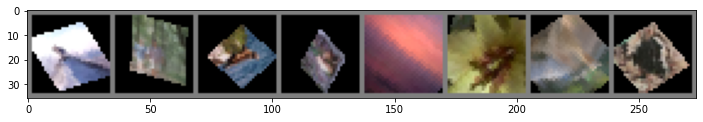

GroundTruth:    mountain,   flatfish,       seal,  mushrooms,        sea,     tulips,      camel,  butterfly
Predicted:         cloud,    leopard,      train,       wolf,     apples,      tiger,    leopard,      skunk


In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images[:8].to(device), labels[:8].to(device)
outputs = inzvaNet(images)
_, predicted = torch.max(outputs.data, 1)
# print images
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ', '.join('%10s' % classes[labels[j]] for j in range(8)))
print('Predicted:   ', ', '.join('%10s' % classes[predicted[j]]for j in range(8)))

In [14]:
# test on all test data
inzvaNet.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = inzvaNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("correct predictions: ", correct)
print("total number of data: ", total)
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

correct predictions:  1229
total number of data:  10000
Accuracy of the network on the 10000 test images: 12 %


In [16]:
# class-wise accuracy
class_correct = list(0. for i in range(100))
class_total = list(0. for i in range(100))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = inzvaNet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print("Accuracy of classes:")
for i in range(100):
    print('%3d- %20s : %5.3f %%' % (
        i+1, classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of classes:
  1-               apples : 23.000 %
  2-        aquarium fish : 9.000 %
  3-                 baby : 10.000 %
  4-                 bear : 9.000 %
  5-               beaver : 12.000 %
  6-                  bed : 1.000 %
  7-                  bee : 4.000 %
  8-               beetle : 13.000 %
  9-              bicycle : 2.000 %
 10-              bottles : 0.000 %
 11-                bowls : 0.000 %
 12-                  boy : 0.000 %
 13-               bridge : 4.000 %
 14-                  bus : 7.000 %
 15-            butterfly : 6.000 %
 16-                camel : 8.000 %
 17-                 cans : 0.000 %
 18-               castle : 26.000 %
 19-          caterpillar : 28.000 %
 20-               cattle : 2.000 %
 21-                chair : 13.000 %
 22-           chimpanzee : 36.000 %
 23-                clock : 0.000 %
 24-                cloud : 52.000 %
 25-            cockroach : 44.000 %
 26-    computer keyboard : 0.000 %
 27-                couch : 1.000

### Hyper-Parameter Optimization

In [17]:
# installing optuna
import subprocess
command = "pip install --no-input optuna"
process = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True, shell=True)
stdout_raw = process.stdout.strip().upper()
stderr_raw = process.stderr.strip().upper()
if len(stderr_raw) > 0:
    print(stderr_raw)
    raise RuntimeError("ERROR: Could not execute shell command '{}'".format(command))
print(stdout_raw)
print("Done.")

REQUIREMENT ALREADY SATISFIED: OPTUNA IN D:\ANACONDA3\ENVS\MYENV001\LIB\SITE-PACKAGES (2.10.0)
REQUIREMENT ALREADY SATISFIED: SQLALCHEMY>=1.1.0 IN D:\ANACONDA3\ENVS\MYENV001\LIB\SITE-PACKAGES (FROM OPTUNA) (1.4.29)
REQUIREMENT ALREADY SATISFIED: SCIPY!=1.4.0 IN D:\ANACONDA3\ENVS\MYENV001\LIB\SITE-PACKAGES (FROM OPTUNA) (1.5.2)
REQUIREMENT ALREADY SATISFIED: COLORLOG IN D:\ANACONDA3\ENVS\MYENV001\LIB\SITE-PACKAGES (FROM OPTUNA) (6.6.0)
REQUIREMENT ALREADY SATISFIED: TQDM IN D:\ANACONDA3\ENVS\MYENV001\LIB\SITE-PACKAGES (FROM OPTUNA) (4.62.3)
REQUIREMENT ALREADY SATISFIED: CMAES>=0.8.2 IN D:\ANACONDA3\ENVS\MYENV001\LIB\SITE-PACKAGES (FROM OPTUNA) (0.8.2)
REQUIREMENT ALREADY SATISFIED: ALEMBIC IN D:\ANACONDA3\ENVS\MYENV001\LIB\SITE-PACKAGES (FROM OPTUNA) (1.7.5)
REQUIREMENT ALREADY SATISFIED: PYYAML IN D:\ANACONDA3\ENVS\MYENV001\LIB\SITE-PACKAGES (FROM OPTUNA) (6.0)
REQUIREMENT ALREADY SATISFIED: PACKAGING>=20.0 IN D:\ANACONDA3\ENVS\MYENV001\LIB\SITE-PACKAGES (FROM OPTUNA) (21.3)
REQUIREME

In [6]:
import optuna
from optuna.samplers import TPESampler

In [8]:
# Function that runs through training and returns the validation loss to be optimized
def objective(trial):

    # Cleaning up GPU
    torch.cuda.empty_cache()

    # Defining hyperparameter space
    hparams = {
    'input_image_size':[32, 32],
    'batch_size': 256,
    'epochs': 10,
    'lr': 0.001,
    'loss_function': nn.CrossEntropyLoss(),
    'optimizer':trial.suggest_categorical('optimizer', ['adam', 'sgd']),
    'optimizer_params':None,
    'num_conv_blocks': trial.suggest_int("num_conv_blocks", 2, 5),
    'num_dense_layers':trial.suggest_int("num_dense_layers", 1, 5),
    'conv_kernel_size':trial.suggest_int("conv_kernel_size", 2, 10),
    'pool_kernel_size':trial.suggest_int("pool_kernel_size", 2, 5),
    'conv_padding':'same',
    'pool_padding':0,
    'conv_activations':trial.suggest_categorical("conv_activations", ['relu', 'leakyrelu', 'sigmoid', 'tanh']),
    'dense_activations':trial.suggest_categorical("dense_activations", ['relu', 'leakyrelu', 'sigmoid', 'tanh']),
    'conv_batchnorm':trial.suggest_categorical("conv_batchnorm", ["before", "after"]),
    'dense_batchnorm':trial.suggest_categorical("dense_batchnorm", ["before", "after"]),
    'conv_stride':1,
    'pool_stride':1,
    'conv_dropout':trial.suggest_float("conv_dropout", 0.1, 0.5),
    'dense_dropout':trial.suggest_float("dense_dropout", 0.1, 0.5),
    'L2':0.001,
    'num_classes':100}

    # Defining hyperparameter conditions
    hparams['pool_padding'] = hparams['pool_kernel_size']//2
    if hparams['optimizer'] == 'sgd':
        hparams['optimizer_params'] = {'momentum':0.9}
    

    # Generate data
    allset = torchvision.datasets.CIFAR100(root='./data/CIFAR100', train=True, download=True, transform=transform)
    num_all_data = len(allset.data)
    num_val_data, num_train_data = int(VALIDATION_DATA*num_all_data), int((1-VALIDATION_DATA)*num_all_data)
    (trainset, valset) = random_split(allset, (num_train_data, num_val_data), generator=torch.Generator().manual_seed(42))
    trainloader = DataLoader(trainset, batch_size=hparams['batch_size'], shuffle=True, num_workers=0)
    validloader = DataLoader(valset, batch_size=hparams['batch_size'], shuffle=True, num_workers=0)
    
    # Build and train the model as we did before
    inzvaNet = ConvNet(hparams)
    inzvaNet.to(device)
    inzvaNet.train()
    criterion = hparams['loss_function']
    if hparams['optimizer']=='adam':
        if hparams.get('optimizer_params'):
            optimizer = optim.Adam(inzvaNet.parameters(), lr=hparams['lr'], **hparams['optimizer_params'])
        else:
            optimizer = optim.Adam(inzvaNet.parameters(), lr=hparams['lr'])
    elif hparams['optimizer']=='sgd':
        if hparams.get('optimizer_params'):
            optimizer = optim.SGD(inzvaNet.parameters(), lr=hparams['lr'], **hparams['optimizer_params'])
        else:
            optimizer = optim.SGD(inzvaNet.parameters(), lr=hparams['lr'])
    num_training_batches = len(trainloader)
    num_validation_batches = len(validloader)

    for epoch in range(hparams["epochs"]):
        
        epoch_loss_training = 0.0
        epoch_loss_validation = 0.0

        inzvaNet.train()
        for i, data in enumerate(trainloader):
            images, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            predictions = inzvaNet(images)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            epoch_loss_training += loss.item()

        inzvaNet.eval()
        with torch.no_grad():
            for i, data in enumerate(validloader):
                images, labels = data[0].to(device), data[1].to(device)
                predictions = inzvaNet(images)
                loss = criterion(predictions, labels)
                epoch_loss_validation += loss.item()

        print("Epoch:  %2d\t|Training Loss:   %.3f\t|Validation Loss:   %.3f" % (epoch + 1, 
            epoch_loss_training / num_training_batches, 
            epoch_loss_validation / num_validation_batches))

    return epoch_loss_validation 

In [9]:
# Create HPO study
study = optuna.create_study(sampler=TPESampler(), direction="minimize")

# Optimize HPO study
tStart = timer()
study.optimize(objective, n_trials=NUM_HPO_TRIALS, timeout=HPO_TIMEOUT_SEC, n_jobs=NUM_HPO_JOBS, catch=(Exception,))
tFinish = timer()

# Report
print("HPO process took %d seconds."%(tFinish-tStart))
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print(trial)
print("\tBest Validation Loss: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-01-24 03:21:21,604] A new study created in memory with name: no-name-1f2b7940-f244-4b78-be45-831a171969cd


Files already downloaded and verified


D:\Anaconda3\envs\myEnv001\lib\site-packages\torch\nn\modules\conv.py:442: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ..\aten\src\ATen\native\Convolution.cpp:647.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch:   1	|Training Loss:   4.679	|Validation Loss:   4.425
Epoch:   2	|Training Loss:   4.527	|Validation Loss:   4.337
Epoch:   3	|Training Loss:   4.447	|Validation Loss:   4.281
Epoch:   4	|Training Loss:   4.389	|Validation Loss:   4.231
Epoch:   5	|Training Loss:   4.342	|Validation Loss:   4.189
Epoch:   6	|Training Loss:   4.290	|Validation Loss:   4.148
Epoch:   7	|Training Loss:   4.260	|Validation Loss:   4.120
Epoch:   8	|Training Loss:   4.226	|Validation Loss:   4.071
Epoch:   9	|Training Loss:   4.197	|Validation Loss:   4.063


[I 2022-01-24 03:38:16,548] Trial 0 finished with value: 160.976891040802 and parameters: {'optimizer': 'sgd', 'num_conv_blocks': 3, 'num_dense_layers': 4, 'conv_kernel_size': 4, 'pool_kernel_size': 5, 'conv_activations': 'relu', 'dense_activations': 'leakyrelu', 'conv_batchnorm': 'before', 'dense_batchnorm': 'after', 'conv_dropout': 0.19179270727092163, 'dense_dropout': 0.25768620210213067}. Best is trial 0 with value: 160.976891040802.


Epoch:  10	|Training Loss:   4.172	|Validation Loss:   4.024
Files already downloaded and verified
Epoch:   1	|Training Loss:   4.667	|Validation Loss:   4.611
Epoch:   2	|Training Loss:   4.628	|Validation Loss:   4.510
Epoch:   3	|Training Loss:   4.547	|Validation Loss:   4.428
Epoch:   4	|Training Loss:   4.485	|Validation Loss:   4.387
Epoch:   5	|Training Loss:   4.445	|Validation Loss:   4.362
Epoch:   6	|Training Loss:   4.424	|Validation Loss:   4.356
Epoch:   7	|Training Loss:   4.407	|Validation Loss:   4.330
Epoch:   8	|Training Loss:   4.395	|Validation Loss:   4.330
Epoch:   9	|Training Loss:   4.377	|Validation Loss:   4.362


[I 2022-01-24 03:55:07,186] Trial 1 finished with value: 171.43050575256348 and parameters: {'optimizer': 'adam', 'num_conv_blocks': 4, 'num_dense_layers': 2, 'conv_kernel_size': 2, 'pool_kernel_size': 5, 'conv_activations': 'sigmoid', 'dense_activations': 'leakyrelu', 'conv_batchnorm': 'before', 'dense_batchnorm': 'before', 'conv_dropout': 0.4005373293909916, 'dense_dropout': 0.12951364524530612}. Best is trial 0 with value: 160.976891040802.


Epoch:  10	|Training Loss:   4.350	|Validation Loss:   4.286
Files already downloaded and verified
Epoch:   1	|Training Loss:   4.657	|Validation Loss:   4.359
Epoch:   2	|Training Loss:   4.520	|Validation Loss:   4.283
Epoch:   3	|Training Loss:   4.457	|Validation Loss:   4.221
Epoch:   4	|Training Loss:   4.417	|Validation Loss:   4.192
Epoch:   5	|Training Loss:   4.373	|Validation Loss:   4.179
Epoch:   6	|Training Loss:   4.348	|Validation Loss:   4.124
Epoch:   7	|Training Loss:   4.326	|Validation Loss:   4.100
Epoch:   8	|Training Loss:   4.298	|Validation Loss:   4.081
Epoch:   9	|Training Loss:   4.287	|Validation Loss:   4.062


[I 2022-01-24 04:10:04,541] Trial 2 finished with value: 162.40307450294495 and parameters: {'optimizer': 'sgd', 'num_conv_blocks': 2, 'num_dense_layers': 2, 'conv_kernel_size': 5, 'pool_kernel_size': 2, 'conv_activations': 'tanh', 'dense_activations': 'tanh', 'conv_batchnorm': 'after', 'dense_batchnorm': 'after', 'conv_dropout': 0.4945721582411171, 'dense_dropout': 0.3600449294674264}. Best is trial 0 with value: 160.976891040802.


Epoch:  10	|Training Loss:   4.265	|Validation Loss:   4.060
Files already downloaded and verified
Epoch:   1	|Training Loss:   4.657	|Validation Loss:   4.467
Epoch:   2	|Training Loss:   4.554	|Validation Loss:   4.378
Epoch:   3	|Training Loss:   4.483	|Validation Loss:   4.323
Epoch:   4	|Training Loss:   4.425	|Validation Loss:   4.269
Epoch:   5	|Training Loss:   4.385	|Validation Loss:   4.225
Epoch:   6	|Training Loss:   4.348	|Validation Loss:   4.194
Epoch:   7	|Training Loss:   4.313	|Validation Loss:   4.181
Epoch:   8	|Training Loss:   4.289	|Validation Loss:   4.124
Epoch:   9	|Training Loss:   4.263	|Validation Loss:   4.107


[I 2022-01-24 04:29:34,390] Trial 3 finished with value: 163.596444606781 and parameters: {'optimizer': 'sgd', 'num_conv_blocks': 4, 'num_dense_layers': 3, 'conv_kernel_size': 8, 'pool_kernel_size': 3, 'conv_activations': 'tanh', 'dense_activations': 'leakyrelu', 'conv_batchnorm': 'before', 'dense_batchnorm': 'before', 'conv_dropout': 0.12940670912374097, 'dense_dropout': 0.44156351204304856}. Best is trial 0 with value: 160.976891040802.


Epoch:  10	|Training Loss:   4.241	|Validation Loss:   4.090
Files already downloaded and verified
Epoch:   1	|Training Loss:   4.611	|Validation Loss:   4.347
Epoch:   2	|Training Loss:   4.466	|Validation Loss:   4.303
Epoch:   3	|Training Loss:   4.411	|Validation Loss:   4.263
Epoch:   4	|Training Loss:   4.372	|Validation Loss:   4.198
Epoch:   5	|Training Loss:   4.334	|Validation Loss:   4.168
Epoch:   6	|Training Loss:   4.317	|Validation Loss:   4.127
Epoch:   7	|Training Loss:   4.296	|Validation Loss:   4.145
Epoch:   8	|Training Loss:   4.286	|Validation Loss:   4.138
Epoch:   9	|Training Loss:   4.272	|Validation Loss:   4.077


[I 2022-01-24 04:45:15,816] Trial 4 finished with value: 163.43482208251953 and parameters: {'optimizer': 'adam', 'num_conv_blocks': 3, 'num_dense_layers': 4, 'conv_kernel_size': 2, 'pool_kernel_size': 4, 'conv_activations': 'relu', 'dense_activations': 'tanh', 'conv_batchnorm': 'before', 'dense_batchnorm': 'after', 'conv_dropout': 0.3430825134068658, 'dense_dropout': 0.21658675460165494}. Best is trial 0 with value: 160.976891040802.


Epoch:  10	|Training Loss:   4.262	|Validation Loss:   4.086
Files already downloaded and verified
Epoch:   1	|Training Loss:   4.370	|Validation Loss:   4.137
Epoch:   2	|Training Loss:   4.197	|Validation Loss:   4.026
Epoch:   3	|Training Loss:   4.119	|Validation Loss:   3.950
Epoch:   4	|Training Loss:   4.071	|Validation Loss:   3.899
Epoch:   5	|Training Loss:   4.032	|Validation Loss:   3.854
Epoch:   6	|Training Loss:   3.994	|Validation Loss:   3.795
Epoch:   7	|Training Loss:   3.966	|Validation Loss:   3.783
Epoch:   8	|Training Loss:   3.938	|Validation Loss:   3.760
Epoch:   9	|Training Loss:   3.911	|Validation Loss:   3.724


[I 2022-01-24 05:00:24,257] Trial 5 finished with value: 148.07879781723022 and parameters: {'optimizer': 'adam', 'num_conv_blocks': 2, 'num_dense_layers': 1, 'conv_kernel_size': 9, 'pool_kernel_size': 2, 'conv_activations': 'relu', 'dense_activations': 'leakyrelu', 'conv_batchnorm': 'after', 'dense_batchnorm': 'before', 'conv_dropout': 0.41786473811059455, 'dense_dropout': 0.16982388420062394}. Best is trial 5 with value: 148.07879781723022.


Epoch:  10	|Training Loss:   3.894	|Validation Loss:   3.702
Files already downloaded and verified
Epoch:   1	|Training Loss:   4.674	|Validation Loss:   4.626
Epoch:   2	|Training Loss:   4.651	|Validation Loss:   4.614
Epoch:   3	|Training Loss:   4.644	|Validation Loss:   4.606
Epoch:   4	|Training Loss:   4.637	|Validation Loss:   4.602
Epoch:   5	|Training Loss:   4.637	|Validation Loss:   4.599
Epoch:   6	|Training Loss:   4.631	|Validation Loss:   4.597
Epoch:   7	|Training Loss:   4.631	|Validation Loss:   4.594
Epoch:   8	|Training Loss:   4.628	|Validation Loss:   4.590
Epoch:   9	|Training Loss:   4.629	|Validation Loss:   4.587


[I 2022-01-24 05:15:32,249] Trial 6 finished with value: 183.25664234161377 and parameters: {'optimizer': 'sgd', 'num_conv_blocks': 2, 'num_dense_layers': 2, 'conv_kernel_size': 8, 'pool_kernel_size': 3, 'conv_activations': 'sigmoid', 'dense_activations': 'sigmoid', 'conv_batchnorm': 'before', 'dense_batchnorm': 'before', 'conv_dropout': 0.4962010530402665, 'dense_dropout': 0.3713930295322787}. Best is trial 5 with value: 148.07879781723022.


Epoch:  10	|Training Loss:   4.623	|Validation Loss:   4.581
Files already downloaded and verified
Epoch:   1	|Training Loss:   4.581	|Validation Loss:   4.283
Epoch:   2	|Training Loss:   4.339	|Validation Loss:   4.136
Epoch:   3	|Training Loss:   4.235	|Validation Loss:   4.068
Epoch:   4	|Training Loss:   4.180	|Validation Loss:   3.992
Epoch:   5	|Training Loss:   4.137	|Validation Loss:   3.953
Epoch:   6	|Training Loss:   4.099	|Validation Loss:   3.913
Epoch:   7	|Training Loss:   4.071	|Validation Loss:   3.878
Epoch:   8	|Training Loss:   4.047	|Validation Loss:   3.841
Epoch:   9	|Training Loss:   4.031	|Validation Loss:   3.812


[I 2022-01-24 05:31:27,581] Trial 7 finished with value: 152.01260638237 and parameters: {'optimizer': 'adam', 'num_conv_blocks': 4, 'num_dense_layers': 1, 'conv_kernel_size': 3, 'pool_kernel_size': 5, 'conv_activations': 'relu', 'dense_activations': 'leakyrelu', 'conv_batchnorm': 'after', 'dense_batchnorm': 'after', 'conv_dropout': 0.4260640048050487, 'dense_dropout': 0.3556335650272967}. Best is trial 5 with value: 148.07879781723022.


Epoch:  10	|Training Loss:   4.008	|Validation Loss:   3.800
Files already downloaded and verified
Epoch:   1	|Training Loss:   4.494	|Validation Loss:   4.186
Epoch:   2	|Training Loss:   4.301	|Validation Loss:   4.124
Epoch:   3	|Training Loss:   4.243	|Validation Loss:   4.094
Epoch:   4	|Training Loss:   4.201	|Validation Loss:   4.067
Epoch:   5	|Training Loss:   4.179	|Validation Loss:   4.045
Epoch:   6	|Training Loss:   4.157	|Validation Loss:   4.019
Epoch:   7	|Training Loss:   4.144	|Validation Loss:   4.027
Epoch:   8	|Training Loss:   4.145	|Validation Loss:   4.001
Epoch:   9	|Training Loss:   4.122	|Validation Loss:   3.987


[I 2022-01-24 05:47:01,481] Trial 8 finished with value: 160.26873660087585 and parameters: {'optimizer': 'adam', 'num_conv_blocks': 3, 'num_dense_layers': 3, 'conv_kernel_size': 6, 'pool_kernel_size': 2, 'conv_activations': 'leakyrelu', 'dense_activations': 'sigmoid', 'conv_batchnorm': 'before', 'dense_batchnorm': 'after', 'conv_dropout': 0.13013382314348784, 'dense_dropout': 0.40888582990951783}. Best is trial 5 with value: 148.07879781723022.


Epoch:  10	|Training Loss:   4.109	|Validation Loss:   4.007
Files already downloaded and verified
Epoch:   1	|Training Loss:   4.619	|Validation Loss:   4.452
Epoch:   2	|Training Loss:   4.509	|Validation Loss:   4.364
Epoch:   3	|Training Loss:   4.445	|Validation Loss:   4.305
Epoch:   4	|Training Loss:   4.387	|Validation Loss:   4.252
Epoch:   5	|Training Loss:   4.347	|Validation Loss:   4.212
Epoch:   6	|Training Loss:   4.311	|Validation Loss:   4.189
Epoch:   7	|Training Loss:   4.285	|Validation Loss:   4.156
Epoch:   8	|Training Loss:   4.258	|Validation Loss:   4.118
Epoch:   9	|Training Loss:   4.229	|Validation Loss:   4.091


[I 2022-01-24 06:02:53,443] Trial 9 finished with value: 163.08367204666138 and parameters: {'optimizer': 'sgd', 'num_conv_blocks': 3, 'num_dense_layers': 4, 'conv_kernel_size': 4, 'pool_kernel_size': 2, 'conv_activations': 'tanh', 'dense_activations': 'leakyrelu', 'conv_batchnorm': 'after', 'dense_batchnorm': 'before', 'conv_dropout': 0.3574359087360288, 'dense_dropout': 0.22527667617198507}. Best is trial 5 with value: 148.07879781723022.


Epoch:  10	|Training Loss:   4.210	|Validation Loss:   4.077
HPO process took 9691 seconds.
Number of completed trials: 10
Best trial:
FrozenTrial(number=5, values=[148.07879781723022], datetime_start=datetime.datetime(2022, 1, 24, 4, 45, 15, 817464), datetime_complete=datetime.datetime(2022, 1, 24, 5, 0, 24, 256433), params={'optimizer': 'adam', 'num_conv_blocks': 2, 'num_dense_layers': 1, 'conv_kernel_size': 9, 'pool_kernel_size': 2, 'conv_activations': 'relu', 'dense_activations': 'leakyrelu', 'conv_batchnorm': 'after', 'dense_batchnorm': 'before', 'conv_dropout': 0.41786473811059455, 'dense_dropout': 0.16982388420062394}, distributions={'optimizer': CategoricalDistribution(choices=('adam', 'sgd')), 'num_conv_blocks': IntUniformDistribution(high=5, low=2, step=1), 'num_dense_layers': IntUniformDistribution(high=5, low=1, step=1), 'conv_kernel_size': IntUniformDistribution(high=10, low=2, step=1), 'pool_kernel_size': IntUniformDistribution(high=5, low=2, step=1), 'conv_activations': 

In [14]:
# Selecting the best algorithm
torch.cuda.empty_cache()
best_hparams = trial.params
hparams.update(best_hparams)

# Training model with these parameters
hparams['epochs'] = 80
best_model = ConvNet(hparams)

inzvaNet.to(device)
inzvaNet.train()
criterion = hparams['loss_function']
if hparams['optimizer']=='adam':
    if hparams.get('optimizer_params'):
        optimizer = optim.Adam(inzvaNet.parameters(), lr=hparams['lr'], **hparams['optimizer_params'])
    else:
        optimizer = optim.Adam(inzvaNet.parameters(), lr=hparams['lr'])
elif hparams['optimizer']=='sgd':
    if hparams.get('optimizer_params'):
        optimizer = optim.SGD(inzvaNet.parameters(), lr=hparams['lr'], **hparams['optimizer_params'])
    else:
        optimizer = optim.SGD(inzvaNet.parameters(), lr=hparams['lr'])
num_training_batches = len(trainloader)
num_validation_batches = len(validloader)

print('training starts!')
num_training_batches = len(trainloader)
num_validation_batches = len(validloader)
num_testing_batches = len(testloader)

tStart = timer()
for epoch in range(hparams["epochs"]):
    
    epoch_loss_training = 0.0
    epoch_loss_validation = 0.0

    inzvaNet.train()
    for i, data in enumerate(trainloader):
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        predictions = inzvaNet(images)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss_training += loss.item()

    inzvaNet.eval()
    with torch.no_grad():
        for i, data in enumerate(validloader):
            images, labels = data[0].to(device), data[1].to(device)
            predictions = inzvaNet(images)
            loss = criterion(predictions, labels)
            epoch_loss_validation += loss.item()

    print("Epoch:  %2d\t|Training Loss:   %.3f\t|Validation Loss:   %.3f" % (epoch + 1, 
        epoch_loss_training / num_training_batches, 
        epoch_loss_validation / num_validation_batches))

tFinish = timer()        
print('Finished Training.')
print("Training process took %.2f seconds."%(tFinish-tStart))
print("Saving model...")
try:
    torch.save(inzvaNet, "ConvNet_best.pth")
except Exception as e:
    print(e)
    print("Failed to save the model.")
print("Done saving.")

# Evaluation of the model on testset
inzvaNet.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = inzvaNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("correct predictions: ", correct)
print("total number of data: ", total)
print('Accuracy of the network on all of the test images: %d %%' % (100 * correct / total))

# Class-wise accuracy
class_correct = list(0. for i in range(100))
class_total = list(0. for i in range(100))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = inzvaNet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print("Accuracy of classes:")
for i in range(100):
    print('%3d- %20s : %5.3f %%' % (
        i+1, classes[i], 100 * class_correct[i] / class_total[i]))


training starts!
Epoch:   1	|Training Loss:   3.808	|Validation Loss:   3.634
Epoch:   2	|Training Loss:   3.790	|Validation Loss:   3.617
Epoch:   3	|Training Loss:   3.776	|Validation Loss:   3.596
Epoch:   4	|Training Loss:   3.752	|Validation Loss:   3.581
Epoch:   5	|Training Loss:   3.733	|Validation Loss:   3.582
Epoch:   6	|Training Loss:   3.720	|Validation Loss:   3.579
Epoch:   7	|Training Loss:   3.709	|Validation Loss:   3.541
Epoch:   8	|Training Loss:   3.705	|Validation Loss:   3.539
Epoch:   9	|Training Loss:   3.690	|Validation Loss:   3.539
Epoch:  10	|Training Loss:   3.684	|Validation Loss:   3.532
Epoch:  11	|Training Loss:   3.665	|Validation Loss:   3.492
Epoch:  12	|Training Loss:   3.667	|Validation Loss:   3.477
Epoch:  13	|Training Loss:   3.651	|Validation Loss:   3.494
Epoch:  14	|Training Loss:   3.648	|Validation Loss:   3.491
Epoch:  15	|Training Loss:   3.638	|Validation Loss:   3.463
Epoch:  16	|Training Loss:   3.640	|Validation Loss:   3.478
Epoch: 